In [1]:
import json
import numpy as np
import os
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC

In [2]:
trainData = pd.read_csv('data/petfinder/train.csv')

In [3]:
trainData.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64


<AxesSubplot:>

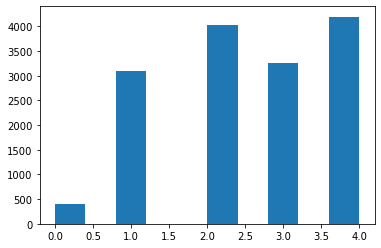

In [4]:
# Adoption speed label
print(trainData['AdoptionSpeed'].value_counts())
trainData['AdoptionSpeed'].hist(grid = False)

In [5]:
print("Total number of pets: ", len(trainData))
print("Total number of unnamed pets: ", sum(trainData['Name'].isna()))

Total number of pets:  14993
Total number of unnamed pets:  1257


In [6]:
trainData.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [7]:
# Adding sentiment features for description.

# Get sentiment dataframe.
def get_description_sentiment_dataframe():

    ids = []
    sentiment_magnitudes = []
    sentiment_scores = []
    
    path = 'data/petfinder/train_sentiment'
    fileList = os.listdir(path)
    
    for filename in fileList:
        file = open(os.path.join(path + '/' + filename), 'r', encoding="utf8")
        
        sentiment = json.load(file)
        
        id = filename.split(".")[0]
        sentiment_magnitude = float(sentiment['documentSentiment']['magnitude'])
        sentiment_score = float(sentiment['documentSentiment']['score'])
        
        ids.append(id)
        sentiment_magnitudes.append(sentiment_magnitude)
        sentiment_scores.append(sentiment_score)
        
    d = {"id": ids, "sentiment_magnitude": sentiment_magnitudes, "sentiment_score": sentiment_scores }
    df = pd.DataFrame(d)
    
    return df
        
sentiment_df = get_description_sentiment_dataframe()
sentiment_df.head(10)

,id,sentiment_magnitude,sentiment_score
0,0008c5398,2.8,0.7
1,000a290e4,0.6,0.3
2,000fb9572,0.8,0.3
3,0011d7c25,0.8,0.8
4,00156db4a,1.8,0.0
5,001a1aaad,3.5,0.2
6,001b1507c,4.7,0.3
7,002230dea,2.0,0.4
8,002278114,11.4,0.1
9,0038234c6,3.0,0.3


In [8]:
# Merging sentiment dataframe with main dataframe.
trainData = trainData.merge(sentiment_df, left_on='PetID', right_on='id', how='left')

In [9]:
# Adding sentiment product: (sentiment * magnitude) as a feature to dataframe.
trainData['SentimentProduct'] = trainData['sentiment_score']*trainData['sentiment_magnitude']

In [10]:
trainData.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed', 'id',
       'sentiment_magnitude', 'sentiment_score', 'SentimentProduct'],
      dtype='object')

In [11]:
categoricalFeatures = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', \
                       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', \
                       'Sterilized', 'Health', 'State']

numericalFeatures = ['Age', 'Quantity', 'Fee', 'VideoAmt',  'PhotoAmt',\
                    'sentiment_magnitude', 'sentiment_score', 'SentimentProduct']

features = categoricalFeatures + numericalFeatures

In [12]:
# Transforming columns.
labelEncoder = sklearn.preprocessing.LabelEncoder()
trainData['AdoptionSpeed'] = labelEncoder.fit_transform(trainData['AdoptionSpeed'])
    
# Transform features into categorical.
for c in categoricalFeatures:
        trainData[c] = trainData[c].astype('category')
        
# Transform features into float.
for c in numericalFeatures:
        trainData[c] = trainData[c].astype('float')
        
# Fill N/A values with zero for sentiment
trainData = trainData.fillna(value={'sentiment_magnitude': 1, 'sentiment_score': 1, 'SentimentProduct': 1})

In [13]:
# Splitting into train and test set.
x_train, x_test, y_train, y_test = train_test_split(trainData[features], trainData['AdoptionSpeed'], \
                                                    test_size=0.33, shuffle=True)

In [14]:
# Training a decision tree classifier for testing.
decisionTree = sklearn.tree.DecisionTreeClassifier(random_state=0)

decisionTree.fit(x_train, y_train)
        
decisionTreePredictions = decisionTree.predict(x_test)

print("F1 Score:", f1_score(y_test, decisionTreePredictions, average='macro'))
print("Accuracy Score:", accuracy_score(y_test, decisionTreePredictions))
print("Recall Score:", recall_score(y_test, decisionTreePredictions, average='macro'))

F1 Score: 0.2878603540403051
Accuracy Score: 0.33852061438965236
Recall Score: 0.28831783679787665


In [26]:
# Function for training and outputing test results for a model.
def train_and_test_model(model):
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    
    print("F1 Score:", f1_score(y_test, predictions, average='macro'))
    print("Accuracy Score:", accuracy_score(y_test, predictions))
    print("Recall Score:", recall_score(y_test, predictions, average='macro'))
    
    if hasattr(model, 'feature_importances_'):
        print("Feature Importances: ")
        for feature, importance in zip(features, model.feature_importances_):
            print('feature: {f}, importance: {i}'.format(f=feature, i=importance))
    print()
    

# Function for training and outputing test results for a collection of models.
def train_and_test_model_collection(models):
    for model_name, model in models.items():
        print("Training and testing model:", model_name)
        train_and_test_model(model)
        print("=====")

In [27]:
# Training and testing multiple models.
model_collection = { 'Decision Tree' : sklearn.tree.DecisionTreeClassifier(random_state=0), \
                     'Support Vector Machine' : sklearn.svm.SVC(decision_function_shape='ovr'), \
                     'Bernoulli Naive Bayes' : BernoulliNB(), \
                     'Gaussian Naive Bayes' : GaussianNB(), \
                     'Multi-layer Perceptron Classifier' : MLPClassifier(random_state = 0), \
                     'KNN Classifier' : KNeighborsClassifier(n_neighbors=6), \
                     'Bagging Extra Tree Classifier' : BaggingClassifier(ExtraTreeClassifier(random_state=0), random_state=0), \
                     'Random Forest Classifier' : RandomForestClassifier(max_depth=20, random_state=0), \
                     'Gradient Boosting Classifier' : GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, \
                                                                                 max_depth=10, random_state=0), \
                     'Ada Boost Classifier' : AdaBoostClassifier(n_estimators=100, random_state=0),
                     'Bagging Classifier (Decision Trees)' : BaggingClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier(random_state=0), n_estimators=10, random_state=0)}

train_and_test_model_collection(model_collection)

Training and testing model: Decision Tree
F1 Score: 0.2878603540403051
Accuracy Score: 0.33852061438965236
Recall Score: 0.28831783679787665
Feature Importances: 
feature: Type, importance: 0.002263771956503166
feature: Breed1, importance: 0.056069020297630785
feature: Breed2, importance: 0.032814110905483744
feature: Gender, importance: 0.02746906076083665
feature: Color1, importance: 0.058233574609887845
feature: Color2, importance: 0.056357043187000466
feature: Color3, importance: 0.026465393905174325
feature: MaturitySize, importance: 0.027593045752866845
feature: FurLength, importance: 0.028004670761806932
feature: Vaccinated, importance: 0.027277042159200165
feature: Dewormed, importance: 0.02663654087058362
feature: Sterilized, importance: 0.023757808411242545
feature: Health, importance: 0.0070797734418872335
feature: State, importance: 0.048248047598138735
feature: Age, importance: 0.08536287443740675
feature: Quantity, importance: 0.027958987645857376
feature: Fee, importance